In [1]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
import itertools

import copy
random.seed(10)

In [2]:
img_dir = '/Users/ida/Google Drive/Big Data Econometrics/Slides/images/'

In [3]:
def fn_generate_cov(dim,corr):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar,corr)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()
    
def fn_group_to_ind(vecG,n_g):
    """
    Transform group effects vector of length G into an n-length individual effects vector 
    """
#     g = len(vecG)
#     return np.concatenate([np.concatenate([vecG[g] for i in range(n_g)]) for g in range(G)]).\
#     reshape([n,1])
    return np.array(list(itertools.chain.from_iterable(itertools.repeat(x,n_g) for x in vecG)))

def fn_ind_to_panel(vec,T):
    """
    Transform (n x 1) vector of individual specific effect to an (n x T) matrix
    """
    return np.concatenate([vec for i in range(T)],axis =1)

def fn_mat_wide_to_long(mat,n,T):
    """
    Take (n x T) matrix and output nxT vector with observations for each t stacked on top
    """
    return np.concatenate([mat[:,i] for i in range(T)]).reshape([n*T,1])

def fn_create_wide_to_long_df(data,colnames,n,G,T):
    """
    Take list of matrices in wide format and output a dataframe in long format
    """
    n_g = n/G # number of observations in each group
    if n_g.is_integer()==False:
        print('Error: n_g is not an integer')
    else:
        n_g = int(n_g)
    group = np.concatenate([fn_group_to_ind(np.array(range(G)).reshape([G,1]),n_g) for i in range(T)])
    if len(data)!=len(colnames):
        print('Error: number of column names not equal to number of variables')
    dataDict = {}
    for i in range(len(colnames)):
        dataDict[colnames[i]] = fn_mat_wide_to_long(data[i],n,T)[:,0]

    dataDict['group'] = group[:,0]+1
    dataDict['n'] = 1+np.concatenate([range(n) for i in range(T)])
    dataDict['t'] = 1+np.array(list(itertools.chain.from_iterable(itertools.repeat(i,n) for i in range(T))))
    return pd.DataFrame(dataDict)

def fn_generate_grouped_panel(n,G,T,n_treated,treat_start,beta,delta,linear_trend = False):
    n_g = n/G # number of observations in each group
    if n_g.is_integer()==False:
        print('Error: n_g is not an integer')
    else:
        n_g = int(n_g)

    alphaG = np.random.normal(1,1,[G,1]) # (G x 1) group fixed effects
    alpha_i = fn_group_to_ind(alphaG,n_g) # (n x 1)
    treatG = np.zeros([G,1])
    treatG[:n_treated,] = 1
    treat_i = fn_group_to_ind(treatG,n_g) # (n x 1)
    # convert to (n X T)
    if linear_trend==True:
        gamma = np.vstack([np.array(range(T)) for i in range(n)])
    else:
        gamma = np.ones([n,1])*np.random.normal(0,1,[1,T]) # (n x T) # time specific effects   
    alpha = fn_ind_to_panel(alpha_i,T)
    treat = fn_ind_to_panel(treat_i,T)
    treat = np.concatenate([0*treat[:,:treat_start],treat[:,treat_start:]],axis = 1)
    
    sig = (np.random.chisquare(2,[n,1])/4+0.5)**(1/2)
    eps = sig*((np.random.chisquare(2,[n,T])-2)*0.5) # (n x T)
    X = np.concatenate([fn_generate_multnorm(n,.5,1) for i in range(T)],axis =1) # (n x T)
    Y = alpha + gamma + beta*treat + delta*X+eps
    
    return [Y,alpha,gamma,treat,X]

def fn_plot_dd(dfg,treat_start,fig_name=False):
    """
    Plot average outcome Y by group
    """
    
    Yg = dfg[['Y','I','group','t']].groupby(['group','t']).mean().reset_index()
    treatStatus = dict(zip(Yg[Yg.t==Yg.t.max()]['group'],Yg[Yg.t==Yg.t.max()]['I']))
    fig = plt.figure(figsize = (10,6))
    for g in Yg.group.unique():
        plt.plot(Yg[Yg.group==g]['t'],Yg[Yg.group==g]['Y'],label = 'treatment={}'.format(int(treatStatus[g])))
    plt.axvline(x=treat_start+1,color = 'red')
    plt.xlabel('time period')
    plt.ylabel('outcome')
    plt.legend()
    if fig_name:
        plt.savefig(img_dir + 'dd1.png')
        
def fn_within_transformation(dfg,varlist,group_var):
    """
    Transform each variable in the varlist using the within transformation to eliminate
    the group-fixed effects
    """
    dfm = dfg[varlist+[group_var]].groupby([group_var]).mean().\
                reset_index().\
                rename(columns = {k:'{}_bar'.format(k) for k in varlist})
    dfg = dfg.merge(dfm, on = ['group'],how = 'left')
    dfg['const'] = 1
    for v in varlist:
        dfg['{}_w'.format(v)] = dfg[v] - dfg['{}_bar'.format(v)]
    return dfg

Statsmodels sandwich variance estimators
https://github.com/statsmodels/statsmodels/blob/master/statsmodels/stats/sandwich_covariance.py

## 1. Generate data

$Y_{it} = W_{it}\tau_{it}+\mu_i+\delta_t+\varepsilon_{it}$

$\varepsilon_{it}^{\left(  r\right)  }/\sigma_{i}\sim IID\left[\chi^{2}(2)-2\right]  /2$

$\sigma_{i}^{2}\sim IID\left[  \chi^{2}(2)/4+0.5\right]$ 

Text(0.5, 1.0, 'Distribution of errors')

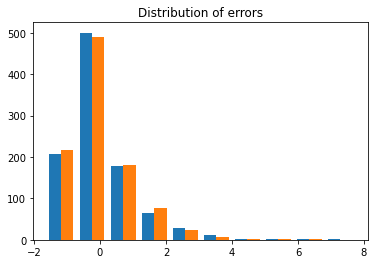

In [4]:
n = 1000
T = 2
t_treat = 2# first treatment period
p = 0.5
tau = 2
mu = np.random.normal(1,1,[n,1]) # (n x 1)
sig = (np.random.chisquare(2,[n,1])/4+0.5)**(1/2)
eps = sig*((np.random.chisquare(2,[n,T])-2)*0.5) # (n x T)
# eps = np.random.normal([n,T])
delta = np.ones([n,1])*np.random.normal(0,1,[1,T]) # (n x T)
treat = fn_randomize_treatment(n,p) # (n x 1)
W = np.concatenate([np.zeros([n,t_treat-1]),treat*np.ones([n,T-t_treat+1])],axis = 1)
Y = W*tau+mu+delta+eps
Yt = Y[np.where(treat==1)[0],:]
Yc = Y[np.where(treat==0)[0],:]
plt.hist(eps)
plt.title('Distribution of errors')

Estimate parameter of interest by running a regression of $\Delta Y_{i1}$ on the treatment indicator and an intercept

In [5]:
Ydiff = Y[:,1]-Y[:,0]
Wmod = copy.deepcopy(W)
Wmod[:,0] = 1
model = sm.OLS(Ydiff,Wmod)

In [6]:
# res = model.fit()
# res.summary()

In [7]:
Yt_diff = np.mean(Yt[:,1])-np.mean(Yt[:,0])
Yc_diff = np.mean(Yc[:,1])-np.mean(Yc[:,0])
Yt_diff - Yc_diff

2.017574857434594

In [8]:
v_Y = np.concatenate([Y[:,i] for i in range(T)]).reshape([2*n,1])
# v_W = np.concatenate([W[:,i] for i in range(T)]).reshape([2*n,1])
v_W = np.concatenate([W[:,1] for i in range(T)]).reshape([2*n,1])
v_mu = np.concatenate([mu for i in range(T)])
v_n = np.concatenate([range(1,n+1) for i in range(T)]).reshape([2*n,1])
v_t = np.concatenate([i*np.ones([n,1]) for i in range(1,T+1)])

In [9]:
df = pd.DataFrame({'y':v_Y[:,0],
                   'W':v_W[:,0],
                   'mu':v_mu[:,0],
                   'n':v_n[:,0],
                   't':v_t[:,0]})

Now let $T_i = 1$ if $t=2$ and $T_i=0$ otherwise and run regression

$Y_i = \alpha+W_{i1}+T_i+W_{i1}*T_i$

In [10]:
df['Ti'] = 1*(df.t==2)
df['const'] = 1
df['int'] = df.W*df.Ti

In [11]:
# mod = sm.OLS(df.y,df[['const','W','Ti','int']])
# res = mod.fit()
# res.summary()

## Let's focus on the more interesting case where we observe multiple time periods and multiple groups

$Y_{igt} = \alpha_g+\gamma_t+\beta I_{gt}+\delta X_{igt}+\varepsilon_{igt}$

Assessing DD identification the key identifying assumption in DD models is that the treatment stateshave similar trends to the control states in the absence of treatment

In [12]:
n = 2
G = 2
n_treated = 1
T = 20

beta = 20
delta = 1
treat_start = 10

Plot the outcome for the treatment and control group

In [13]:
linear_trend = True
[Y,alpha,gamma,treat,X]= fn_generate_grouped_panel(n,G,T,n_treated,treat_start,beta,delta,linear_trend)

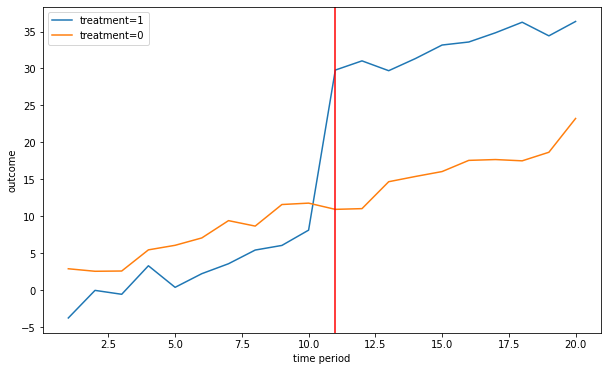

In [14]:
colnames = ['Y','alpha','gamma','I','X']
data = [Y,alpha,gamma,treat,X]

dfg = fn_create_wide_to_long_df(data,colnames,n,G,T)
fn_plot_dd(dfg,treat_start)

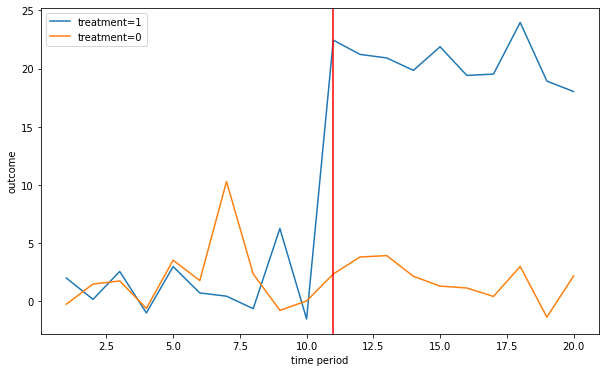

In [15]:
linear_trend = False
[Y,alpha,gamma,treat,X]= fn_generate_grouped_panel(n,G,T,n_treated,treat_start,beta,delta,linear_trend)
colnames = ['Y','alpha','gamma','I','X']
data = [Y,alpha,gamma,treat,X]

dfg = fn_create_wide_to_long_df(data,colnames,n,G,T)
fn_plot_dd(dfg,treat_start)

### Estimation

In [16]:
data = [Y,alpha,gamma,treat,X]
colnames = ['Y','alpha','gamma','I','X']

dfg = fn_create_wide_to_long_df(data,colnames,n,G,T)

dfg = fn_within_transformation(dfg,colnames,'group')   

In [17]:
# dfg.head()

#### Estimation using a full set of time and group dummies

In [18]:
xvars = pd.concat([dfg[['I','X']],
                   pd.get_dummies(dfg['group'],drop_first = False),
                   pd.get_dummies(dfg['t'],drop_first = False)],axis = 1)
mod = sm.OLS(dfg['Y'],xvars)
res = mod.fit()
# res.summary()

#### Estimation using a within group transformation

In [19]:
xvars = pd.concat([dfg[['I_w','X_w']],
                  pd.get_dummies(dfg['t'])],axis = 1)
mod = sm.OLS(dfg['Y_w'],xvars)
res = mod.fit()
# res.summary()

### Multiple groups and time periods

$Y_{igt} = \alpha_g+\gamma_t+\beta I_{gt}+\delta X_{igt}+\varepsilon_{igt}$


In [20]:
n = 1000
G = 10
n_treated = 5
T = 20

beta = 20
delta = 1
treat_start = 10


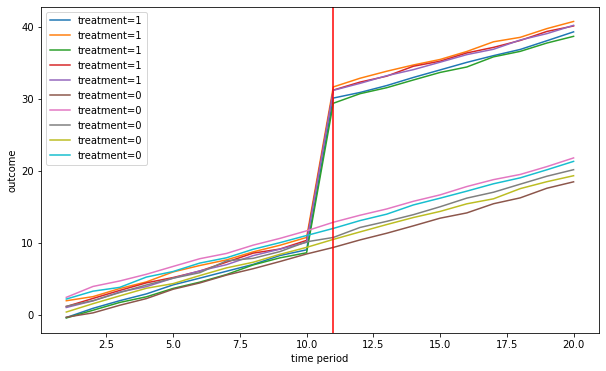

In [21]:
linear_trend = True
[Y,alpha,gamma,treat,X]= fn_generate_grouped_panel(n,G,T,n_treated,treat_start,beta,delta,linear_trend)
colnames = ['Y','alpha','gamma','I','X']
data = [Y,alpha,gamma,treat,X]
dfg = fn_create_wide_to_long_df(data,colnames,n,G,T)
fn_plot_dd(dfg,treat_start)
# dfg.head()

### Estimation


In [22]:
dfw = fn_within_transformation(dfg,colnames,'group')   

In [23]:
xvars = pd.concat([dfw[['I_w','X_w']],
                  pd.get_dummies(dfw['t'])],axis = 1)
mod = sm.OLS(dfw['Y_w'],xvars,cluster= dfw['group'])
res = mod.fit(cov_type='HC1')
t = res.params.I_w/res.HC1_se.I_w

### Simulate placebo policy

In [24]:
def fn_placebo_treatment(row,tstart,treated):
    if (row.t>=tstart) & (row.group in treated):
        return 1
    else:
        return 0

In [25]:
R = 100
l = []
n = 1000
G = 10
n_treated = 1
T = 20

beta = 20
delta = 1
treat_start = 10
linear_trend = True
colnames = ['Y','alpha','gamma','I','X']

for r in tqdm(range(R)):
    np.random.seed(r)
    [Y,alpha,gamma,treat,X]= fn_generate_grouped_panel(n,G,T,n_treated,treat_start,beta,delta,linear_trend)
    data = [Y,alpha,gamma,treat,X]
    dfg = fn_create_wide_to_long_df(data,colnames,n,G,T)
    tstart = random.choice(range(dfg.t.min(),dfg.t.max()+1))
    treated = random.choices(range(dfg.group.min(),dfg.group.max()+1),k = int(dfg.group.max()/2))
    dfg['I'] = dfg.apply(lambda row: fn_placebo_treatment(row,tstart,treated),axis = 1)
    dfw = fn_within_transformation(dfg,colnames,'group')  
    xvars = pd.concat([dfw[['I_w','X_w']],
                  pd.get_dummies(dfw['t'])],axis = 1)
    mod = sm.OLS(dfw['Y_w'],xvars,cluster= dfw['group'])
    res = mod.fit(cov_type='HC1')
    t = res.params.I_w/res.HC1_se.I_w
    if np.abs(t)>1.96:
        l = l+[1]
    else:
        l = l+[0]

  5%|▌         | 5/100 [00:01<00:30,  3.13it/s]<ipython-input-25-a10acc4bd6bc>:27: RuntimeWarning: invalid value encountered in double_scalars
  t = res.params.I_w/res.HC1_se.I_w
100%|██████████| 100/100 [00:32<00:00,  3.09it/s]


In [26]:
np.mean(l) # we reject

0.94

### Now let's add some serial correlation to the DGP

In [27]:
n = 1000
G = 10
n_treated = 5
T = 20

beta = 20
delta = 1
treat_start = 10

linear_trend = True
serial_corr = True
[Y,alpha,gamma,treat,X]= fn_generate_grouped_panel(n,G,T,n_treated,treat_start,beta,delta,linear_trend,serial_corr)
colnames = ['Y','alpha','gamma','I','X']
data = [Y,alpha,gamma,treat,X]
dfg = fn_create_wide_to_long_df(data,colnames,n,G,T)
fn_plot_dd(dfg,treat_start)

TypeError: fn_generate_grouped_panel() takes from 7 to 8 positional arguments but 9 were given

In [ ]:
def fn_generate_grouped_panel(n,G,T,n_treated,treat_start,beta,delta,linear_trend = False,corr = False):
    n_g = n/G # number of observations in each group
    if n_g.is_integer()==False:
        return print('Error: n_g is not an integer')

    else:
        n_g = int(n_g)

        alphaG = np.random.normal(1,1,[G,1]) # (G x 1) group fixed effects
        alpha_i = fn_group_to_ind(alphaG,n_g) # (n x 1)
        treatG = np.zeros([G,1])
        treatG[:n_treated,] = 1
        treat_i = fn_group_to_ind(treatG,n_g) # (n x 1)
        # convert to (n X T)
        if linear_trend==True:
            gamma = np.vstack([np.array(range(T)) for i in range(n)])
        else:
            gamma = np.ones([n,1])*np.random.normal(0,1,[1,T]) # (n x T) # time specific effects   
        alpha = fn_ind_to_panel(alpha_i,T)
        treat = fn_ind_to_panel(treat_i,T)
        treat = np.concatenate([0*treat[:,:treat_start],treat[:,treat_start:]],axis = 1)

        sig = (np.random.chisquare(2,[n,1])/4+0.5)**(1/2)
        eps = sig*((np.random.chisquare(2,[n,T])-2)*0.5) # (n x T)
        
        if corr == True:
            rho = .7
            u = np.zeros(eps.shape)
            u[:,0] = eps[:,0]
            for t in range(1,T):
                u[:,t] = rho*u[:,t-1]+eps[:,t]
                
        X = np.concatenate([fn_generate_multnorm(n,.5,1) for i in range(T)],axis =1) # (n x T)
        if corr == False:
            Y = alpha + gamma + beta*treat + delta*X+eps
        else:
            Y = alpha + gamma + beta*treat + delta*X + u

        return [Y,alpha,gamma,treat,X]

In [ ]:
def fn_run_mc(beta,R,corr):
    l0 = []
    l1 = []
    for r in tqdm(range(R)):
        np.random.seed(r)
        [Y,alpha,gamma,treat,X]= fn_generate_grouped_panel(n,G,T,n_treated,treat_start,beta,delta,linear_trend,corr)
        data = [Y,alpha,gamma,treat,X]
        dfg = fn_create_wide_to_long_df(data,colnames,n,G,T)
        tstart = random.choice(range(dfg.t.min(),dfg.t.max()+1))
        treated = random.choices(range(dfg.group.min(),dfg.group.max()+1),k = int(dfg.group.max()/2))
    #     dfg['I'] = dfg.apply(lambda row: fn_placebo_treatment(row,tstart,treated),axis = 1)
        dfw = fn_within_transformation(dfg,colnames,'group')  
        xvars = pd.concat([dfw[['I_w','X_w']],
                      pd.get_dummies(dfw['t'])],axis = 1)
        mod = sm.OLS(dfw['Y_w'],xvars,cluster= dfw['group'])
        res = mod.fit(cov_type='HC1')
        t0 = res.params.I_w/res.HC1_se.I_w
        t1 = (res.params.I_w-beta)/res.HC1_se.I_w

        l0 = l0 + [1*(np.abs(t0)>1.96)]
        l1 = l1 + [1*(np.abs(t1)>1.96)]

    return np.mean(l0),np.mean(l1)

In [ ]:
R = 500
n = 1000
G = 10
n_treated = 5
T = 20
delta = 1
treat_start = 10
linear_trend = True
colnames = ['Y','alpha','gamma','I','X']


##### Treatment effect = 2 with no serial correlation

In [ ]:
beta = 2
corr = False

h1, hb = fn_run_mc(beta,R,corr)
h1,hb

##### Treatment effect = 2 with serial correlation

In [ ]:
beta = 2
corr = True

h1, hb = fn_run_mc(beta,R,corr)
h1,hb

##### Treatment effect = 0, no serial correlation

In [ ]:
beta = 0
corr = False

h1, hb = fn_run_mc(beta,R,corr)
print('We reject beta=0 {}% of the time'.format(h1))

##### Treatment effect = 0, serial correlation

In [ ]:
beta = 0
corr = True

h1, hb = fn_run_mc(beta,R,corr)
print('We reject beta=0 {}% of the time'.format(h1))

## Sentsitivity tests

Redo the analysis on pre-event years - the estiamted treatment effect should be zero!
Are treatment and control gropus similar along observable dimensions?
Make sure the change is concentrated around the event
Make sure tha tother outcome variables that should be unaffected by the event are indeed unaffected